In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import glob
import re
import gc

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from dask.distributed import Client
from IPython.display import IFrame

from tqdm.notebook import tqdm

from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.linear_model import (LinearRegression,
                                  TheilSenRegressor,
                                  RANSACRegressor,
                                  HuberRegressor,
                                  RidgeCV,
                                  LassoCV)
import mrcfile
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

from SIFT_gs.FIBSEM_SIFT_gs import FIBSEM_frame, FIBSEM_dataset
from SIFT_gs.FIBSEM_SIFT_gs import get_min_max_thresholds
from SIFT_gs.FIBSEM_SIFT_gs import (ShiftTransform,
                                    XScaleShiftTransform,
                                    ScaleShiftTransform,
                                    RegularizedAffineTransform)
            
from SIFT_gs.FIBSEM_SIFT_gs import (generate_report_mill_rate_xlsx,
                                    generate_report_FOV_center_shift_xlsx,
                                    generate_report_data_minmax_xlsx,
                                    generate_report_ScanRate_EHT_xlsx,
                                    generate_report_transf_matrix_from_xlsx,
                                    generate_report_from_xls_registration_summary,
                                    plot_registrtion_quality_xlsx,
                                    read_kwargs_xlsx)
                        
from SIFT_gs.FIBSEM_SIFT_gs import plot_cross_sections_mrc_stack, add_scale_bar
from SIFT_gs.FIBSEM_SIFT_gs import (bin_crop_mrc_stack,
                                    show_eval_box_mrc_stack)
from SIFT_gs.FIBSEM_SIFT_gs import plot_2D_blob_results, plot_2D_blob_examples
from SIFT_gs.FIBSEM_SIFT_gs import build_kernel_FFT_zero_destreaker_XY, build_kernel_FFT_zero_destreaker_radii_angles
from SIFT_gs.FIBSEM_SIFT_gs import (destreak_mrc_stack_with_kernel,
                                    destreak_single_frame_kernel_shared,
                                    smooth_mrc_stack_with_kernel)

Open CV version:  4.6.0
SIFT_gs version:  4.0.1


In [8]:
def line_correlation(stack, center, step, nsteps, line_axis, correlation_axis):
    '''
    Computes line-to-line normalaized zero-mean correlation within 3D stack. gleb.shtengel@gmail.com
    
    Parameters:
        stack : 3D array
            vEM data stack
        center : list or array of thre coordintes - through which the reference correlation line goes
        step: int 
            # of pixel in a single shift step
        nsteps : int
            # of offset steps to compute correlation
        line_axis : int
            axis of the line to be correlated. 0=z, 1=y, 2=x
        correlation_axis : int
            axis of the correlation displacement. 0=z, 1=y, 2=x
    
    Returns:
        ncc : float
        normalized zero-mean cross-correlation
    '''
    cz, cy, cx = center
    ncc = []
    ir = 3 - line_axis - correlation_axis  # "remaining" axis
    c_corr = center[correlation_axis]
    c_rem = center[ir]
    
    '''
    original axes: 
    0, 1, 2
    
    Axes for correlation:
    corr_direction, line_direction, remaining_direction
    
    line_axis = X ( or 2)
    correlation_axis = Y (or 1)
    should be 1, 2, 0
    0, 1, 2 -> np.swapaxes(stack, correlation_axis, 0) -> 1, 0, 2
    1, 0, 2 -> np.swapaxes(stack, line_axis, 1) -> 1, 2, 0  - correct
    
    line_axis = X ( or 2)
    correlation_axis = Z (or 0)
    should be 0, 2, 1
    0, 1, 2 -> np.swapaxes(stack, correlation_axis, 0) -> 0, 1, 2
    0, 1, 2 -> np.swapaxes(stack, line_axis, 1) -> 0, 2, 1  - correct
    
    line_axis = Y ( or 1)
    correlation_axis = Z (or 0)
    should be 0, 1, 2
    0, 1, 2 -> np.swapaxes(stack, line_axis, 1) -> 0, 1, 2  - correct
    
    line_axis = Y ( or 1)
    correlation_axis = X (or 2)
    should be 2, 1, 0
    0, 1, 2 -> np.swapaxes(stack, correlation_axis, 0) -> 2, 1, 0
    2, 1, 0 -> np.swapaxes(stack, line_axis, 1) -> 2, 1, 0  - correct
    
    line_axis = Z ( or 0)
    correlation_axis = X (or 2)
    should be 2, 0, 1
    0, 1, 2 -> np.swapaxes(stack, line_axis, 1) -> 1, 0, 2
    1, 0, 2 -> np.swapaxes(stack, correlation_axis, 0) -> 2, 0, 1 - correct
    
    line_axis = Z ( or 0)
    correlation_axis = Y (or 1)
    should be 1, 0, 2
    0, 1, 2 -> np.swapaxes(stack, line_axis, 1) -> 1, 0, 2
    1, 0, 2 -> np.swapaxes(stack, correlation_axis, 0) -> 1, 0, 2 - correct
    
    '''
    
    if (line_axis + correlation_axis) == 1: #If one of the is 1 and the other is 0, only need to swap once
        new_stack = np.swapaxes(stack, line_axis, 1)
    else:
        if line_axis == 0:
            new_stack = np.swapaxes(np.swapaxes(stack, line_axis, 1), correlation_axis, 0)
        else:
            new_stack = np.swapaxes(np.swapaxes(stack, correlation_axis, 0), line_axis, 1)
    #now the line axis is axis 1, and correlation axis is axis0
    #print('remaining_axis={:d}, coordinate={:d}, correlation_start_coord={:d}'.format(ir, c_rem, c_corr))
    #print(new_stack.shape)
    
    line0 = np.squeeze(new_stack[c_corr, :, c_rem])
    line0 = line0 - line0.mean()
    cs = np.arange(c_corr, c_corr+step*nsteps, step)
    for c in cs:
        line1 = np.squeeze(new_stack[c, :, c_rem])
        line1 = line1 - line1.mean()
        cc00 = np.sum(line0*line0)
        cc11 = np.sum(line1*line1)
        cc10 = np.sum(line0*line1)
        ncc.append(cc10 / np.sqrt(cc00*cc11))

    return ncc

In [2]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address0 = 'http://localhost:{:d}/status'.format(dport)
print('Use ' + status_update_address0 +' to monitor DASK progress')
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

Using Local Port:    8787
Use http://localhost:8787/status to monitor DASK progress


In [3]:
fls_dir0 = os.path.normpath('Y:\Images Jeiss7\Cryo\Y2023')
fls_dir1 = os.path.normpath('Y:\Images Jeiss7\Cryo\Y2023\M10')
days1 = ['M10/D{:02d}'.format(day) for day in np.arange(26, 32)]
fls_dir2 = os.path.normpath('Y:\Images Jeiss7\Cryo\Y2023\M11')
days2 = ['M11/D{:02d}'.format(day) for day in np.arange(1, 11)]

days = days1+days2
days

['M10/D26',
 'M10/D27',
 'M10/D28',
 'M10/D29',
 'M10/D30',
 'M10/D31',
 'M11/D01',
 'M11/D02',
 'M11/D03',
 'M11/D04',
 'M11/D05',
 'M11/D06',
 'M11/D07',
 'M11/D08',
 'M11/D09',
 'M11/D10']

In [4]:
fls=[]
ftype=0
for day in days:
    fls_dir_t = os.path.join(fls_dir0, day)
    if ftype == 0:
        fls1 = sorted(glob.glob(os.path.join(fls_dir_t,'*.dat')))
        if len(fls1) < 1:
            fls1 = sorted(glob.glob(os.path.join(fls_dir_t,'*/*.dat')))
    if ftype == 1:
        fls1 = sorted(glob.glob(os.path.join(fls_dir_t,'*.tif')))
        if len(fls1) < 1:
            fls1 = sorted(glob.glob(os.path.join(fls_dir_t,'*/*.tif')))
    fls = fls + fls1

nfrs = len(fls)
print('Total Number of frames to process: ', nfrs) 

Total Number of frames to process:  8309


In [5]:
test_frame = FIBSEM_frame(fls[nfrs//2])

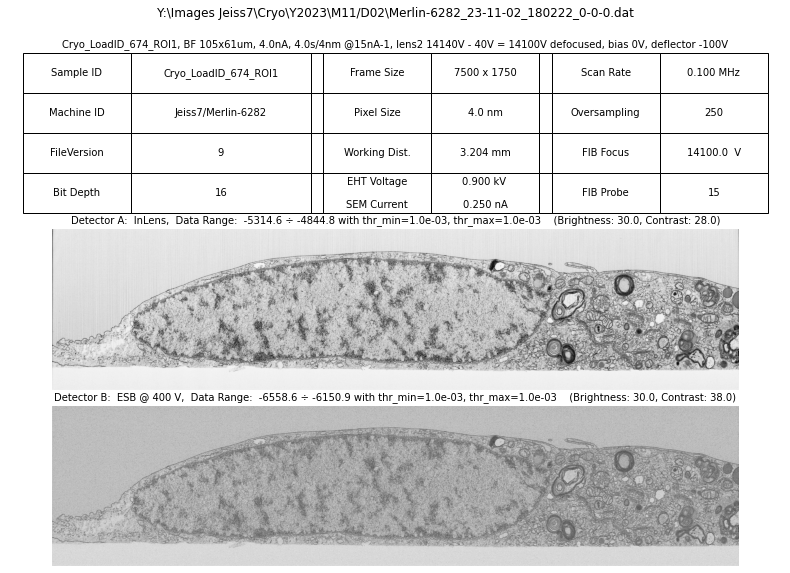

In [6]:
test_frame.save_snapshot()

In [7]:
    line0 = np.squeeze(new_stack[c_corr, :, c_rem])
    line0 = line0 - line0.mean()
    cs = np.arange(c_corr, c_corr+step*nsteps, step)
    for c in cs:
        line1 = np.squeeze(new_stack[c, :, c_rem])
        line1 = line1 - line1.mean()
        cc00 = np.sum(line0*line0)
        cc11 = np.sum(line1*line1)
        cc10 = np.sum(line0*line1)
        ncc.append(cc10 / np.sqrt(cc00*cc11))

In [10]:
from scipy import signal, fftpack
a = np.array([0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 0, 0, 0, 0])
b = np.array([0, 0, 0, 0, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0])
np.argmax(signal.correlate(a,b))

16

In [17]:
ny, nx = test_frame.RawImageA.shape
ny, nx

(1750, 7500)

In [23]:
def sc_corr(a, b):
    A = fftpack.fft(a)
    B = fftpack.fft(b)
    Ar = -A.conjugate()
    return np.argmax(np.abs(fftpack.ifft(Ar*B)))

  0%|          | 0/1749 [00:00<?, ?it/s]

Wall time: 4.06 s


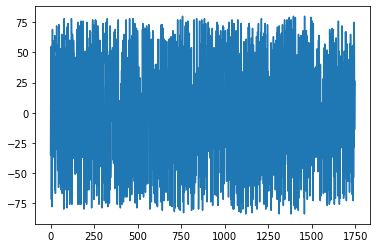

In [19]:
%%time
corr = np.zeros(ny-1)
for j in tqdm(np.arange(ny-1)):
    corr_loc = np.mod(np.argmax(signal.correlate(test_frame.RawImageA[j],test_frame.RawImageA[j+1])), nx)
    if corr_loc > nx//2:
        corr[j] = corr_loc - nx
    else:
        corr[j] = corr_loc
plt.plot(corr)

  0%|          | 0/1749 [00:00<?, ?it/s]

Wall time: 1.56 s


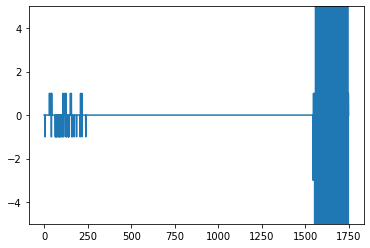

In [27]:
%%time
corr = np.zeros(ny-1)
for j in tqdm(np.arange(ny-1)):
    #corr_loc = np.mod(np.argmax(signal.correlate(test_frame.RawImageA[j],test_frame.RawImageA[j+1])), nx)
    corr_loc = np.mod(sc_corr(test_frame.RawImageA[j],test_frame.RawImageA[j+1]), nx)
    if corr_loc > nx//2:
        corr[j] = corr_loc - nx
    else:
        corr[j] = corr_loc
fig, ax = plt.subplots(1,1)
ax.plot(corr)
ax.set_ylim((-5, 5))

(array([152., 164., 202., 180., 178., 169., 168., 182., 182., 172.]),
 array([-84. , -67.6, -51.2, -34.8, -18.4,  -2. ,  14.4,  30.8,  47.2,
         63.6,  80. ]),
 <BarContainer object of 10 artists>)

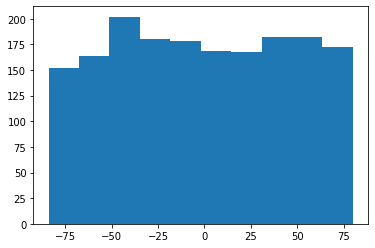

In [20]:
plt.hist(corr)